In [1]:
%run -n ../src/inference.py

In [2]:
device = "cuda"
N, T, batch_size = 5000, 200, 50

train_params = dict(
    distortion=None,
    variable_binning=False,
    start=0.5,
    varying_start_value=True,
    n_agents=N,
    timesteps=T,
    compute_fiv=False,
)

train_loader = DataLoader(train_params, batch_size=batch_size, n_sims=5000, train=True, n_workers=10)

val_params = dict(
    distortion=None,
    variable_binning=False,
    start=0.5,
    varying_start_value=True,
    n_agents=N,
    timesteps=T,
    compute_fiv=False,
)

val_loader = DataLoader(train_params, batch_size=batch_size, n_sims=5000, train=False, n_workers=4)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")

estimator = ConditionalResNetRatioEstimator("RESNET", 1)
model = ConditionalRatioEstimator(estimator, batch_size, device=device)

trainer = Trainer(model, train_loader, val_loader, device=device)
trainer.fit(100, learning_rate=0.001, lr_patience=10, early_stop_patience=50)

trainer.model.cpu()
trainer.model.eval()

Using GPU
Epoch  1: Train loss: 2.742, Val loss: 2.817
Epoch  2: Train loss: 2.378, Val loss: 2.969
Epoch  3: Train loss: 2.004, Val loss: 4.237
Epoch  4: Train loss: 1.922, Val loss: 1.930
Epoch  5: Train loss: 1.749, Val loss: 1.648
Epoch  6: Train loss: 1.793, Val loss: 2.459
Epoch  7: Train loss: 1.645, Val loss: 1.740
Epoch  8: Train loss: 1.629, Val loss: 1.519
Epoch  9: Train loss: 1.553, Val loss: 1.471
Epoch 10: Train loss: 1.633, Val loss: 3.558
Epoch 11: Train loss: 1.456, Val loss: 2.158
Epoch 12: Train loss: 1.539, Val loss: 1.393
Epoch 13: Train loss: 1.470, Val loss: 3.036
Epoch 14: Train loss: 1.394, Val loss: 1.831
Epoch 15: Train loss: 1.397, Val loss: 1.293
Epoch 16: Train loss: 1.400, Val loss: 1.690
Epoch 17: Train loss: 1.409, Val loss: 4.226
Epoch 18: Train loss: 1.432, Val loss: 5.562
Epoch 19: Train loss: 1.431, Val loss: 1.430
Epoch 20: Train loss: 1.361, Val loss: 6.189
Epoch 21: Train loss: 1.346, Val loss: 1.661
Epoch 22: Train loss: 1.386, Val loss: 1.668


ConditionalRatioEstimator(
  (estimator): ConditionalResNetRatioEstimator(
    (net): ResNet(
      (layers): Sequential(
        (0): ResNetBlock(
          (layers): Sequential(
            (0): ConvBlock(
              (layers): Sequential(
                (0): Conv1dSamePadding(1, 64, kernel_size=(8,), stride=(1,))
                (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU()
              )
            )
            (1): ConvBlock(
              (layers): Sequential(
                (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
                (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU()
              )
            )
            (2): ConvBlock(
              (layers): Sequential(
                (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
                (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, tr

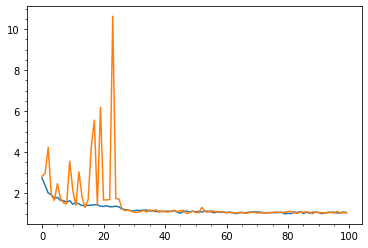

In [3]:
import matplotlib.pyplot as plt

plt.plot(trainer.train_loss)
plt.plot(trainer.val_loss)
plt.minorticks_on()

In [4]:
import torch

resolution = 1000

selection = np.linspace(0, 0.5, resolution)
inputs = torch.FloatTensor(selection)

In [5]:
trainer.model.cpu()
trainer.model.eval()

ConditionalRatioEstimator(
  (estimator): ConditionalResNetRatioEstimator(
    (net): ResNet(
      (layers): Sequential(
        (0): ResNetBlock(
          (layers): Sequential(
            (0): ConvBlock(
              (layers): Sequential(
                (0): Conv1dSamePadding(1, 64, kernel_size=(8,), stride=(1,))
                (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU()
              )
            )
            (1): ConvBlock(
              (layers): Sequential(
                (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
                (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU()
              )
            )
            (2): ConvBlock(
              (layers): Sequential(
                (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
                (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, tr

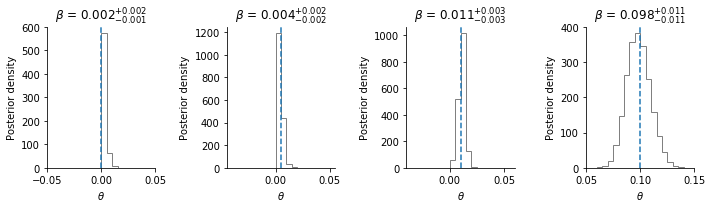

In [40]:
%run -n ../src/simulation.py
%run -n ../src/utils.py

from torch.functional import F

fig, axes = plt.subplots(ncols=4, figsize=(10, 3))

def quantile(x, q, weights=None):
    x = np.atleast_1d(x)
    q = np.atleast_1d(q)

    if np.any(q < 0.0) or np.any(q > 1.0):
        raise ValueError("Quantiles must be between 0 and 1")

    if weights is None:
        return np.percentile(x, list(100.0 * q))
    else:
        weights = np.atleast_1d(weights)
        if len(x) != len(weights):
            raise ValueError("Dimension mismatch: len(weights) != len(x)")
        idx = np.argsort(x)
        sw = weights[idx]
        cdf = np.cumsum(sw)[:-1]
        cdf /= cdf[-1]
        cdf = np.append(0, cdf)
        return np.interp(q, cdf, x[idx]).tolist()

prior = torch.distributions.HalfNormal(0.1) # TODO Hardcoded in dataloader... 

for i, beta in enumerate((0.0, 0.005, 0.01, 0.1)):
    obs = apply_binning(wright_fisher(N, T, beta, start=0.5), 100, N)
    obs = torch.FloatTensor(obs)
    obs = F.pad(obs, (0, T - obs.size(0)))
    outputs = obs.repeat(inputs.size(0), 1).unsqueeze(1)
    with torch.no_grad():
        log_posterior = trainer.model.estimator.log_ratio(inputs, outputs).view(-1) + prior.log_prob(inputs)
    weights = log_posterior.exp()
    axes[i].hist(selection, bins=100, weights=weights, 
                 histtype="step",  color="grey")
    axes[i].axvline(beta, ls="--")
    axes[i].set_xlim(beta - 0.05, beta + 0.05)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    
    axes[i].set_xlabel(r"$\theta$")
    axes[i].set_ylabel("Posterior density")
    
    q_16, q_50, q_84 = quantile(selection, [0.16, 0.5, 0.84], weights=weights)
    q_m, q_p = q_50-q_16, q_84-q_50

    # Format the quantile display.
    fmt = "{{0:{0}}}".format(".3f").format
    title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
    title = title.format(fmt(q_50), fmt(q_m), fmt(q_p))

    title = fr"$\beta$ = {title}"
    
    axes[i].set_title(title)
plt.tight_layout()